# Employee Attrition Risk Prediction

---

A stable workforce is vital for organisation's success, leading to increased productivity, cost effectiveness and retention of institutional knowledge. This project aims to evaluate the risk of employee attrition using Cox Proportional Hazard (CoxPH) and Random Survival Forest (RSF) models, identify factors that influences attrition, and propose intervention strategies.

### Data Source

Our dataset is sourced from [IBM HR analytics synthetic data](https://github.com/IBM/employee-attrition-aif360/), made available under [Open Database License](https://opendatacommons.org/licenses/odbl/1.0/) and [Database Content License](https://opendatacommons.org/licenses/dbcl/1.0/).

### Analysis Tool

We will be using R for our data analysis.

---

## Performing Data Wrangling

After importing the dataset, we first skim the data and check for duplicates, empty values, data types and ranges.

In [1]:
# Importing data
rm(list = ls())
hr <- read.csv("hr_data.csv")

# First few rows
head(hr)
# Number of duplicated rows
nrow(hr[duplicated(hr), ])
# Number of empty values
sum(is.na(hr))
# All column's range and type
summary(hr)
sapply(hr, function(x) {
  unique_vals <- sort(unique(x))
  return(unique_vals)
})

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


[1] 0

[1] 0

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1470        Length:1470        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 465.0  
 Median :36.00   Mode  :character   Mode  :character   Median : 802.0  
 Mean   :36.92                                         Mean   : 802.5  
 3rd Qu.:43.00                                         3rd Qu.:1157.0  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1470        Min.   : 1.000   Min.   :1.000   Length:1470       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.193   Mean   :2.913                     
                    3rd Qu.:14.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

$Age
 [1] 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42
[26] 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60

$Attrition
[1] "No"  "Yes"

$BusinessTravel
[1] "Non-Travel"        "Travel_Frequently" "Travel_Rarely"    

$DailyRate
  [1]  102  103  104  105  106  107  109  111  115  116  117  118  119  120  121
 [16]  124  125  128  129  130  131  132  134  135  136  138  140  141  142  143
 [31]  144  145  146  147  148  150  152  153  154  155  156  157  160  161  163
 [46]  164  167  168  170  172  174  176  177  179  180  181  182  185  188  189
 [61]  192  193  194  195  196  199  200  201  202  203  204  205  206  207  208
 [76]  210  211  213  216  217  218  219  224  228  230  231  232  234  237  238
 [91]  240  241  243  244  247  248  249  251  252  253  254  256  258  261  263
[106]  264  265  266  267  268  269  271  277  279  280  282  285  286  287  288
[121]  289  290  294  296  299  300  301  302  303  304  305  306  307  309  310
[136]  311  313  314  316  317  318  319  322  325  326  328  329  330  332  333
[151]  334  335  336  337  341  342  343  345  346  350  352  355  359  360  362
[166]  363  364  365  367  369  370  371  373  374  376  377  379  381  383  384
[181]  390  391  392  394  395  397  401  404  405  406  408  410  412  413  414
[196]  415  419  422  426  427  428  429  430  431  432  433  436  437  438  439
[211]  440  441  442  443  444  446  447  448  452  457  458  459  461  462  464
[226]  465  466  467  468  469  470  471  472  474  477  478  479  480  481  482
[241]  483  486  488  489  490  492  495  496  498  499  500  501  504  505  506
[256]  507  508  509  511  515  516  523  524  525  526  527  528  529  530  531
[271]  532  534  535  536  538  541  542  543  544  546  548  549  552  553  555
[286]  556  557  558  559  560  561  562  563  566  567  570  571  572  573  574
[301]  575  580  581  582  583  584  585  586  587  588  589  590  591  592  593
[316]  594  598  599  600  601  602  603  604  605  607  608  611  613  616  617
[331]  618  619  621  622  625  626  628  629  630  632  634  635  636  638  640
[346]  641  642  644  645  646  647  648  650  652  653  654  655  657  658  660
[361]  661  662  663  664  665  666  667  669  670  671  672  673  674  675  676
[376]  678  682  683  684  685  688  689  691  692  693  694  696  697  699  702
[391]  703  704  705  706  708  711  713  715  717  718  719  720  721  722  723
[406]  725  726  727  728  734  735  736  737  738  740  741  746  748  750  754
[421]  755  756  759  760  763  766  769  770  771  772  773  775  776  781  782
[436]  783  786  788  790  791  792  793  796  797  798  799  801  802  804  805
[451]  806  807  809  810  812  813  817  818  819  821  823  824  827  828  829
[466]  830  832  833  835  836  840  841  845  848  849  852  853  854  855  857
[481]  859  862  866  867  868  869  871  874  878  879  880  881  882  883  884
[496]  885  887  888  889  890  891  894  895  896  897  898  902  903  905  906
[511]  911  913  916  917  918  920  921  922  924  926  928  929  930  931  932
[526]  933  935  937  938  939  942  943  944  945  946  949  950  953  954  955
[541]  956  957  959  964  966  967  968  969  970  971  974  975  976  977  979
[556]  981  982  983  984  986  988  989  990  991  992  994  995  996  999 1001
[571] 1002 1003 1005 1009 1010 1012 1015 1017 1018 1023 1029 1030 1031 1033 1034
[586] 1035 1037 1038 1040 1041 1045 1046 1050 1052 1053 1054 1055 1059 1060 1062
[601] 1063 1064 1065 1066 1069 1070 1075 1076 1079 1082 1083 1084 1085 1086 1089
[616] 1090 1091 1092 1093 1094 1096 1097 1098 1099 1102 1103 1105 1107 1108 1109
[631] 1111 1112 1115 1116 1117 1120 1122 1123 1124 1125 1126 1127 1128 1130 1131
[646] 1132 1134 1136 1137 1138 1141 1142 1144 1145 1146 1147 1150 1151 1153 1154
[661] 1157 1158 1162 1167 1168 1169 1171 1172 1174 1176 1178 1179 1180 1181 1182
[676] 1184 1186 1188 1189 1192 1193 1194 1195 1198 1199 1200 1202 1204 1206 1207
[691] 121

There are issues that we can solve by transforming our data:

1. Some unnecessary variables for analysis, such as the one reflecting unique identification (that is, `EmployeeNumber`) and the single-valued ones (such as `EmployeeCount`).

2. All string variables are categorical, with some variables specifically Boolean.

We will filter `EmployeeNumber` and single-valued variables via column name list to retain original dataset, then adjust the format of categorical variables. For clarity, we convert binary "Yes/No" variables to Boolean type. We treat the rating/level variables as pseudo-continuous to ease our analysis.

A separate exploration conducted by Project Creator indicates possible cross-column consistency issues, particularly from time period columns (`Age`, `TotalWorkingYears`, `Years...`) and income columns (`DailyRate`, `HourlyRate`, `MonthlyIncome`, `MonthlyRate`). These may have been accidentally introduced during the creation process of our synthetic data, and with the lack of complete data column descriptions, we are skipping cleaning this aspect for now. We are also making a mental note that time period columns such as `YearsAtCompany` may have a zero value, perhaps from a round-down of "six months or less".

## Performing Additional Cleaning

In [2]:
# Filter columns
cols <- names(hr)
cols <- cols[cols != "EmployeeNumber"]
single_value_cols <- names(hr)[sapply(hr, function (col) length(unique(col)) == 1)]
cols <- cols[!(cols %in% single_value_cols)]

# Convert column data types
cat_cols <- c("BusinessTravel", "Department", "Gender", "EducationField", "JobRole", "MaritalStatus")
hr[cat_cols] <- lapply(hr[cat_cols], factor)
bool_cols <- c("Attrition", "Over18", "OverTime")
hr[bool_cols] <- lapply(hr[bool_cols], function (col) ifelse(col %in% c("Yes", "Y"), TRUE, FALSE))
                        
head(hr[cols])

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<lgl>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,TRUE,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,FALSE,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,TRUE,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,2,0,7,3,3,0,0,0,0
4,33,FALSE,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,3,0,8,3,3,8,7,3,0
5,27,FALSE,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,4,1,6,3,3,2,2,2,2
6,32,FALSE,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,3,3,0,8,2,2,7,7,3,6


## Outliers

At the very basic, we need to find the outliers of our target variable (in this case, `YearsAtCompany`) in order for our model to generalise well.

In [3]:
outlier_index <- function(df, col) {
    vec <- df[[col]]
    qnt <- quantile(vec, probs = c(0.25, 0.75))
    iqr <- qnt[2] - qnt[1]
    min <- qnt[1] - 3 * iqr
    max <- qnt[2] + 3 * iqr
    return(which(vec < min | vec > max))
}

hr_full_row <- hr
hr <- hr_full_row[-outlier_index(hr_full_row, "YearsAtCompany"), ]

---

## Developing Survival Model

We develop Cox Proportional Hazard and Random Survival Forest models, available from R's library `Survival` and `randomForestSRC`. By [some comparative research on high-dimensional survival data](https://www.nature.com/articles/s41598-020-77220-w), CoxPH with univariate Cox score as feature selection, as well as RSF with variable importance, seem to perform pretty well on empirical data.

Initially we use all our variables as the features, sparing `YearsAtCompany` as the survival time variable and `Attrition` as status variable. The metrics used in feature selection will automatically allow us to understand what contribute to employee's attrition.

We use concordance index (C-index) and Prediction Error Curve (PEC, i.e. integrated Brier score) to measure models' goodness of fit.

Below is the code for various functions used in our modelling:

In [4]:
library(survival)
suppressMessages(library(randomForestSRC))
suppressMessages(library(pec))
library(reshape2)
library(ggplot2)
suppressMessages(library(viridis))

# Models
coxph_model <- function (df) {
  model <- coxph(data = df, formula = Surv(YearsAtCompany, Attrition) ~ ., x = TRUE)
  return(model)
}
rsf_model <- function (df) {
  model <- rfsrc(Surv(YearsAtCompany, Attrition) ~ ., data = df, ntree = 100)
  return(model)
}

# Cross-validation functions
train_test_generate <- function (df, proportion = 0.7) {
  size <- round(proportion * nrow(df))
  idx <- sample(seq_len(nrow(df)), size = size, replace = FALSE)
  return(list("train" = df[idx, ], "test" = df[-idx, ]))
}
cross_val <- function (df, model_f, metric_f, k = 20) {
  for (fold in 1:k) {
    separate <- train_test_generate(df)
    train <- separate$train
    test <- separate$test
    model <- model_f(train)
    if (!(exists("metric_tot"))) {
      metric_tot <- metric_f(test, model)
    } else {
      metric_tot <- metric_tot + metric_f(test, model)
    }
  }
  metric_avg <- metric_tot/k
  return(metric_avg[order(abs(metric_avg), decreasing = TRUE)])
}

# Validation metrics
# 1. Feature rank
# ----- Cox score
coxph_score <- function (df, model) {
  return(summary(model)$coefficients[, "z"]) # the test data is indeed not used
}
print_coxph_var_rank <- function (df) {
  print("Average univariate Cox score:")
  print(cross_val(df, coxph_model, coxph_score))
}
coxph_slope <- function (df, model) {
  return(summary(model)$coefficients[, "coef"])
}
# ----- Importance
rsf_importance <- function (df, model) {
  importance <- predict(model, df, importance = TRUE)$importance
  return(importance)
}
print_rsf_var_rank <- function (df) {
  print("Average variable importance:")
  print(cross_val(df, rsf_model, rsf_importance))
}
# 2. C-index
print_c_index <- function(df, model_f) {
  print("Average concordance index:")
  print(cross_val(df, model_f, function (sub_df, model) {
      unlist(cindex(model, formula = Surv(YearsAtCompany, Attrition) ~ ., data = sub_df)$AppCindex)
  }))
}
print_coxph_var_rank <- function (df, k = 20) {
  print("Average univariate Cox score:")
  print(cross_val(df, coxph_model, coxph_score, k))
}
# 3. PEC
plot_pec <- function(df, model_f) {
  suppressMessages(pred_error <- pec(model_f(df), data = df, formula = Surv(YearsAtCompany, Attrition) ~ .,
                    splitMethod = "cv10", cens.model = "marginal", reference = FALSE))
  plot(pred_error, xlim = c(0, 10), ylim = c(0, 0.25)) # 0.25 is the worst case scenario (random model)
  title("Prediction Error Curve")
}

# Assumption functions
check_proportional_hazard <- function(model) {
  print(cox.zph(model))
}
plot_correlation <- function (df, limit = -1) {
  # Only numerical (unless categories can be continuously extended)
  num_cols <- sapply(df, is.numeric)
  bool_cols <- sapply(df, is.logical)
  df2 <- df[, num_cols | bool_cols]

  # Only select the high-correlated columns
  cor_matrix <- cor(df2)
  high_cor_pairs <- which(cor_matrix >= limit & cor_matrix < 1, arr.ind = TRUE)
  high_cor_cols <- colnames(df2)[high_cor_pairs[, 1]]
  ggplot(data = melt(cor_matrix[high_cor_cols, high_cor_cols]), aes(x = Var1, y = Var2, fill = value)) +
    geom_tile() + scale_fill_viridis() +
    xlab("") + ylab("") + ggtitle("Correlation Map") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
         plot.title = element_text(hjust = 0.5))
}

### First thing first: Another cleaning

The time-dependent variables such as `Age`, `TotalWorkingYears`, `YearsInCurrentRole`, `YearsWithCurrManager` and `YearsSinceLastPromotion` are guaranteed to be always less or always more than the survival time `YearsAtCompanies`. This direclty violates the fundamental concept that a covariate needs to precede an outcome temporally in order to potentially influence/predict it. Thus we will exclude this columns from our features, substituting them with `NotWorkingYears` and `YearsAtOtherCompanies`.

In [5]:
# Removing time-dependent variables
time_dependent_cols <- c("Age", "YearsWithCurrManager", "YearsInCurrentRole",
                         "TotalWorkingYears", "YearsSinceLastPromotion")
cols <- cols[!(cols %in% time_dependent_cols)]
# Adding new non-correlated time variables
new_time_cols <- c("NotWorkingYears", "YearsAtOtherCompanies")
hr_full_row["NotWorkingYears"] <- hr_full_row["Age"] - hr_full_row["TotalWorkingYears"]
hr_full_row["YearsAtOtherCompanies"] <- hr_full_row["TotalWorkingYears"] - hr_full_row["YearsAtCompany"]
cols <- c(cols, new_time_cols)
hr[, cols] <- hr_full_row[-outlier_index(hr_full_row, "YearsAtCompany"), cols]

We also pre-select features that are at least "moderately" independence. This will avoid multicollinearity which breaks the assumption of CoxPH model, while help to improve performance of RSF model. Survival models are generally robust against correlated covariates, hence the decision for "moderately".

From correlation map, we will keep in mind to choose one of the pairs (`JobLevel`, `MonthlyIncome`) and (`PercentSalayHike`, `PerformanceRating`) when performing feature selection.

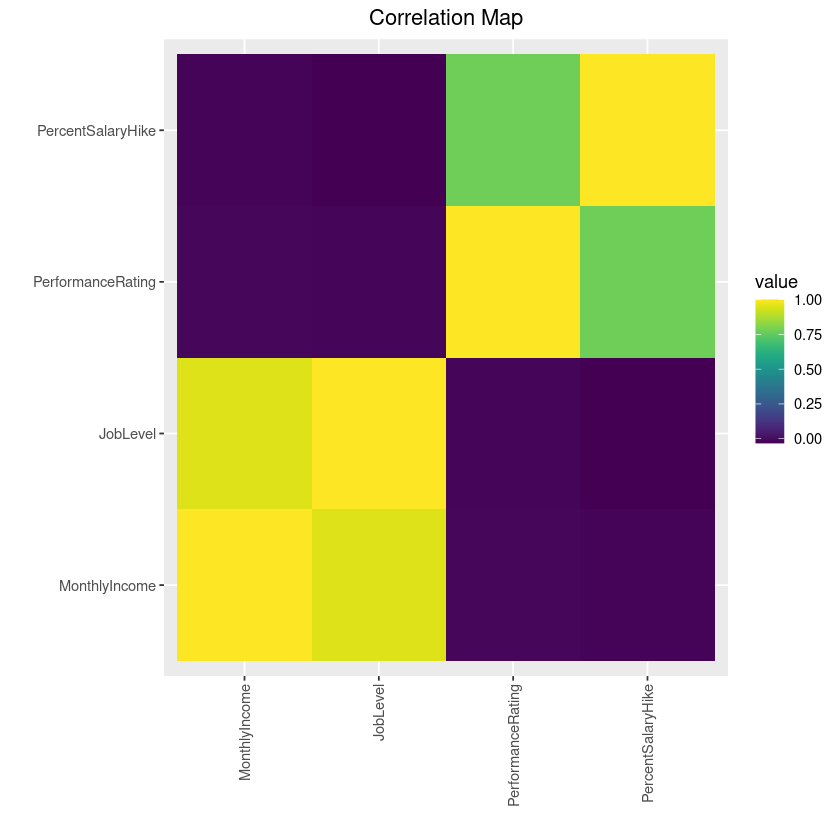

In [6]:
# Correlation
hr1 <- hr[cols]
plot_correlation(hr1, limit = 0.7)

## Feature Selection: CoxPH

There is another assumption of proportional hazard for CoxPH, which can be checked by performing statistical test on Schoenfeld residuals. The warning message from `coxph.fit` and the error message from the wrapper function to perform this suggests that `Department` and `JobRole` should be taken out of calculation due to large fitted coefficients.

The result below suggests that `JobLevel`, `MonthlyIncome`, `NumCompaniesWorked` and `NotWorkingYears` violate this assumption ($p < 0.05$). We remove these from our feature when fitting our initial model.

In [7]:
focus_cols <- cols[!(cols %in% c("Department", "JobRole"))] # coefficient too big
check_proportional_hazard(coxph_model(hr[focus_cols]))

coxph_model_with_TI <- function (df) {
  model <- coxph(data = df, formula = Surv(YearsAtCompany, Attrition) ~ . +
                 JobLevel:YearsAtCompany + MonthlyIncome:YearsAtCompany + NumCompaniesWorked:YearsAtCompany
                 + NotWorkingYears:YearsAtCompany, x = TRUE)
  return(model)
}
check_proportional_hazard(coxph_model_with_TI(hr[focus_cols]))

coxph_cols <- focus_cols[!(focus_cols %in% c("JobLevel", "MonthlyIncome", "NumCompaniesWorked", "NotWorkingYears"))]

                            chisq df       p
BusinessTravel           2.32e+00  2 0.31364
DailyRate                5.71e-02  1 0.81118
DistanceFromHome         2.19e-01  1 0.63954
Education                7.29e-01  1 0.39306
EducationField           3.26e+00  5 0.66027
EnvironmentSatisfaction  1.82e-03  1 0.96601
Gender                   2.17e-01  1 0.64122
HourlyRate               2.60e-01  1 0.60986
JobInvolvement           2.20e-01  1 0.63919
JobLevel                 1.40e+01  1 0.00019
JobSatisfaction          1.37e+00  1 0.24142
MaritalStatus            3.96e+00  2 0.13789
MonthlyIncome            1.82e+01  1   2e-05
MonthlyRate              2.79e+00  1 0.09494
NumCompaniesWorked       5.03e+00  1 0.02493
OverTime                 7.93e-04  1 0.97753
PercentSalaryHike        1.47e+00  1 0.22512
PerformanceRating        2.65e-01  1 0.60696
RelationshipSatisfaction 1.63e-01  1 0.68611
StockOptionLevel         7.36e-02  1 0.78617
TrainingTimesLastYear    3.93e+00  1 0.04757
WorkLifeBa

Warning message in terms.formula(formula, specials = ss, data = data):
“'varlist' has changed (from nvar=25) to new 26 after EncodeVars() -- should no longer happen!”
Warning message in terms.formula(formula, special, data = data):
“'varlist' has changed (from nvar=25) to new 26 after EncodeVars() -- should no longer happen!”
Warning message in coxph(data = df, formula = Surv(YearsAtCompany, Attrition) ~ :
“a variable appears on both the left and right sides of the formula”


                                     chisq df       p
BusinessTravel                    1.55e+00  2 0.46002
DailyRate                         7.07e-02  1 0.79032
DistanceFromHome                  7.27e-01  1 0.39372
Education                         4.81e+00  1 0.02836
EducationField                    1.69e+00  5 0.89009
EnvironmentSatisfaction           4.58e-03  1 0.94606
Gender                            7.37e-01  1 0.39056
HourlyRate                        7.15e-01  1 0.39776
JobInvolvement                    4.06e-01  1 0.52381
JobLevel                          1.27e+02  1 < 2e-16
JobSatisfaction                   3.08e+00  1 0.07939
MaritalStatus                     4.45e+00  2 0.10786
MonthlyIncome                     9.89e+01  1 < 2e-16
MonthlyRate                       8.32e-01  1 0.36182
NumCompaniesWorked                7.91e+01  1 < 2e-16
OverTime                          1.06e-02  1 0.91787
PercentSalaryHike                 3.45e-01  1 0.55716
PerformanceRating           

[1] "Average univariate Cox score:"
                   OverTimeTRUE                  JobInvolvement 
                     7.87599721                     -3.84878306 
                JobSatisfaction         EnvironmentSatisfaction 
                    -3.84008662                     -3.55903774 
BusinessTravelTravel_Frequently             MaritalStatusSingle 
                     3.23026013                      2.84024307 
               DistanceFromHome                      GenderMale 
                     2.76652055                      2.56707236 
    BusinessTravelTravel_Rarely                 WorkLifeBalance 
                     2.09193825                     -2.06023938 
          EducationFieldMedical     EducationFieldLife Sciences 
                    -1.82465479                     -1.79089730 
                      Education           TrainingTimesLastYear 
                    -1.63392816                     -1.47287751 
            EducationFieldOther                       

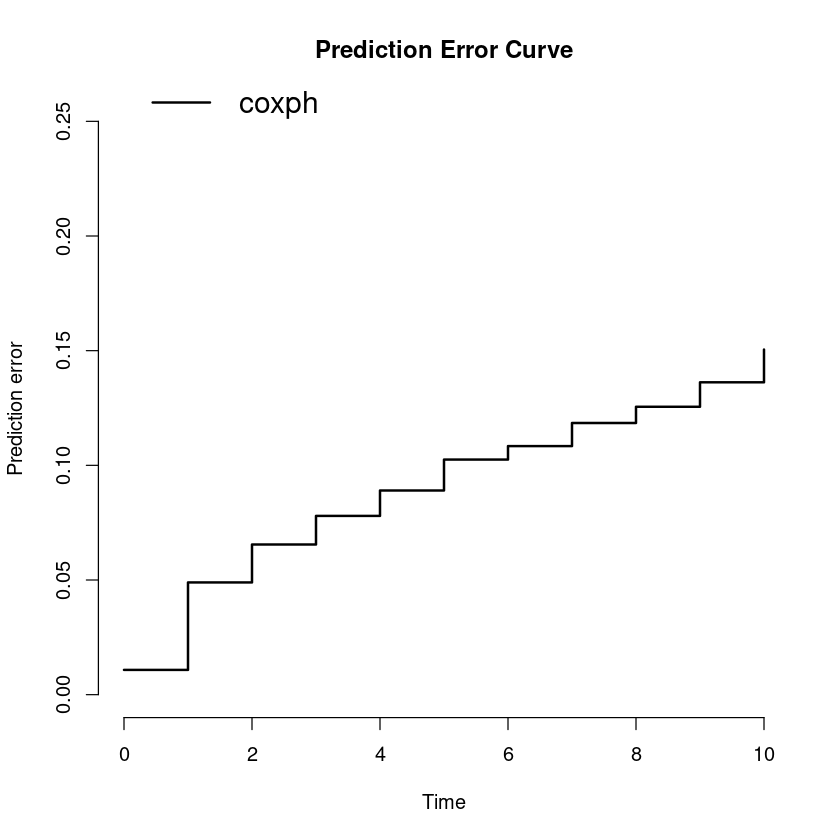

In [8]:
# First iteration
options(warn = -1) # Suppress warnings due to big coxph coefficients

hr1c <- hr[coxph_cols]
print_coxph_var_rank(hr1c)
print_c_index(hr1c, coxph_model)
plot_pec(hr1c, coxph_model)

options(warn = 0) # Reactivate warnings

By selecting significant covariates with $|z| \ge 1.96$ (i.e. $p \le 0.05$), we obtain 9 potential features. The common theme among these features is a connection to workplace welfare, such as `Overtime`, `JobInvolvement`, `JobSatisfaction` and `EnvironmentSatisfaction`. Additionally, `DistanceFromHome` and frequent `BusinessTravel` could be related to proximity to home as an influential factor. Personal elements such as `MaritalStatus` and `Gender` may influence employee retention to a lesser certainty.

The concordance index is around $70-75\%$, while the PEC graph shows that our model has averagely around $90\%$ accuracy ($10\%$ error) in predicting employee attrition within the span of 10 years.

[1] "Average univariate Cox score:"
                   OverTimeTRUE             MaritalStatusSingle 
                      7.6225497                       4.3107203 
                 JobInvolvement                 JobSatisfaction 
                     -4.0480119                      -3.3693217 
        EnvironmentSatisfaction BusinessTravelTravel_Frequently 
                     -3.2704008                       2.8164428 
                     GenderMale                DistanceFromHome 
                      2.5366758                       2.5087040 
    BusinessTravelTravel_Rarely            MaritalStatusMarried 
                      1.7945929                       0.7171233 
[1] "Average concordance index:"
    coxph 
0.7163121 


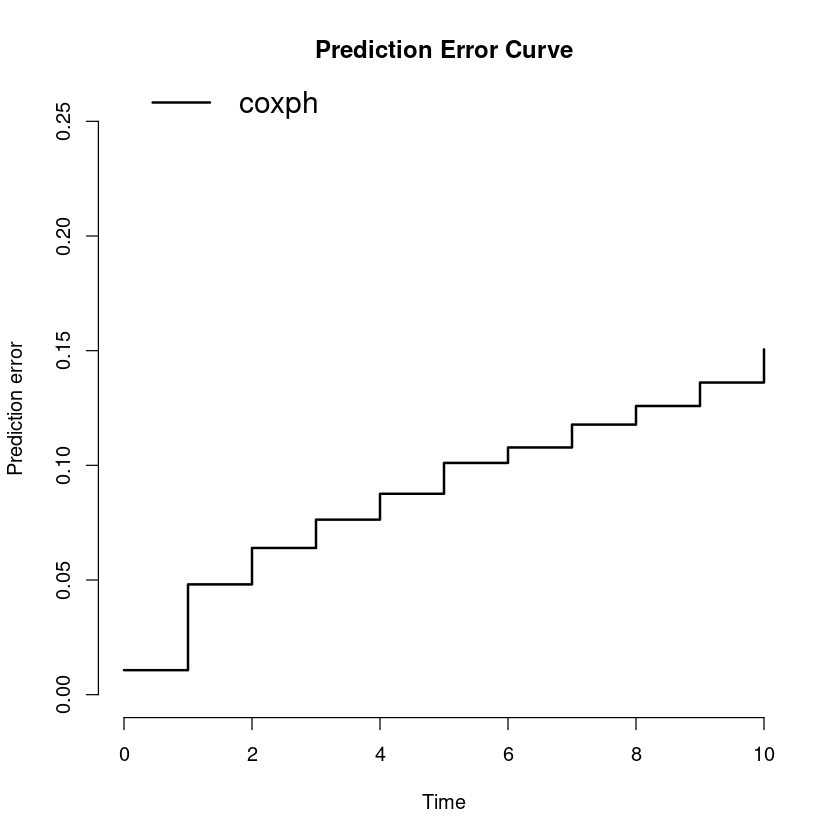

In [9]:
coxph_cols = c("Attrition", "YearsAtCompany", "OverTime", "JobInvolvement", "DistanceFromHome",
               "JobSatisfaction", "BusinessTravel", "EnvironmentSatisfaction", "MaritalStatus", "Gender")
hr1c <- hr[coxph_cols]
print_coxph_var_rank(hr1c)
print_c_index(hr1c, coxph_model)
plot_pec(hr1c, coxph_model)

## Feature Selection: RSF

We develop Random Survival Forest model for our data now. The number of trees used in RSF is on the lower scale (100) for faster process. Note that there is no proportional hazarda assumption here, so the initial feature set can be incorporated here.

[1] "Average variable importance:"
                JobLevel                 OverTime            MonthlyIncome 
            0.1371969634             0.1204838749             0.0977202915 
        StockOptionLevel                  JobRole       NumCompaniesWorked 
            0.0281149109             0.0270184979             0.0200487362 
         NotWorkingYears  EnvironmentSatisfaction            MaritalStatus 
            0.0164769448             0.0164730745             0.0136420302 
         WorkLifeBalance           JobInvolvement         DistanceFromHome 
            0.0127286773             0.0110309277             0.0103663919 
              Department    YearsAtOtherCompanies           EducationField 
            0.0101845948             0.0086534670             0.0058394629 
         JobSatisfaction           BusinessTravel RelationshipSatisfaction 
            0.0054420443             0.0051562776             0.0039452221 
   TrainingTimesLastYear                DailyRate    

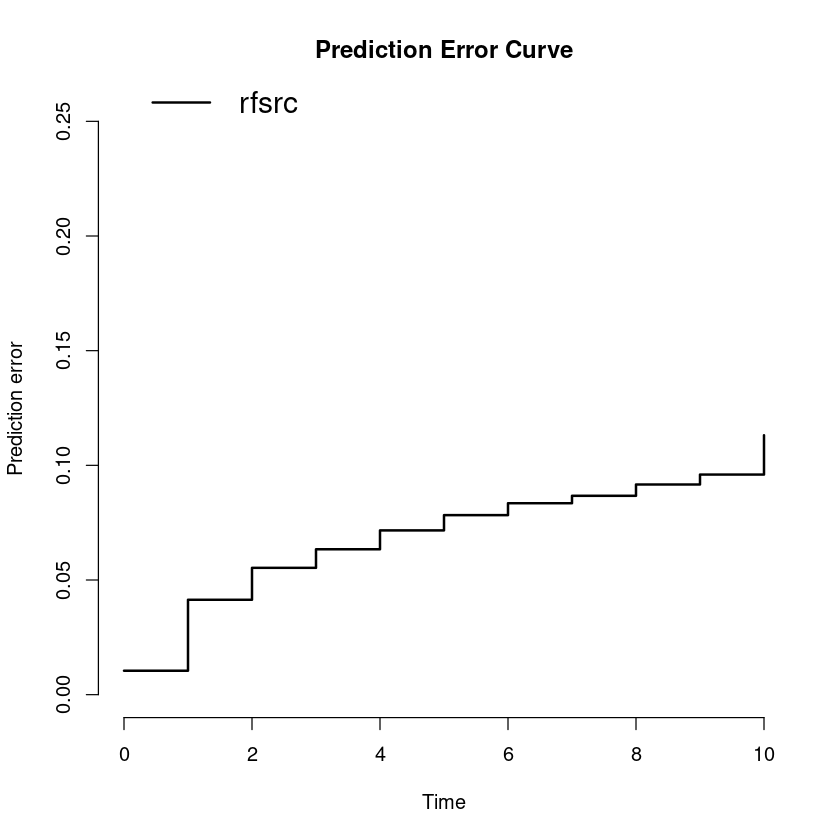

In [10]:
# First iteration
print_rsf_var_rank(hr1)
print_c_index(hr1, rsf_model)
plot_pec(hr1, rsf_model)

The prominent group of importance variables in RSF are `JobLevel`, `OverTime` and `MonthlyIncome`. Again, this is related to work welfare. We note previoiusly that `JobLevel` and `MonthlyIncome` are highly correlated. We pick `JobLevel` for our consideration, just because it has a higher shown importance level.

Other career-related features such as `StockOptionLevel`, `JobRole`, `EnvironmentSatisfaction` and `NumCompaniesWorked` and `NotWorkingYears`, also appear important. The variable `NumCompaniesWorked` can confuse the effect of job-hopping and one of longer work experience. However, since it does not seem to correlate much with `TotalWorkingYears` (not shown), we can somewhat assume that it is an indicator of job-hopping.

The concordance index is better in this case at around $75-80\%$, with PEC error under $7.5\%$ across ten years.

In [ ]:
rsf_cols <- c("Attrition", "YearsAtCompany", "JobLevel", "OverTime", "StockOptionLevel", "JobRole",
              "EnvironmentSatisfaction",  "NumCompaniesWorked", "NotWorkingYears")

hr1r <- hr[rsf_cols]
print_rsf_var_rank(hr1r)
print_c_index(hr1r, rsf_model)
plot_pec(hr1r, rsf_model)

[1] "Average variable importance:"
               JobLevel                OverTime        StockOptionLevel 
             0.27375632              0.14941111              0.07377375 
                JobRole EnvironmentSatisfaction      NumCompaniesWorked 
             0.06711824              0.03233398              0.03024835 
        NotWorkingYears 
             0.01477439 


### Segmenting Attrition Rate

Now, we examine aggregated historical attrition rates for the categorical features `JobRole`:

In [ ]:
suppressMessages(library(dplyr))

aggregated_attrition <- function (df, col) {
  options(warn = -1) # Suppress warnings
    
  # Best for categorical (unless numerical int range is small)
  result <- df[, c("Attrition", col)] %>%
  group_by_(col) %>%
  summarize(
    AttritionCount = sum(Attrition),
    TotalEmployees = n(),
    AttritionRate = AttritionCount/TotalEmployees
  )
    
  options(warn = 0) # Reactivate warnings
  return(result)
}

aggregated_attrition(hr, "JobRole")

Among job positions, managerial positions and Healthcare Representation have around $5\%$ attrition rate, while general positions sit at about $15-25\%$. [A simple online search](https://www.statista.com/statistics/934377/professional-services-worldwide-employee-attrition-by-region/) shows an average of $10-18\%$ global churn rate in 2022, so this company's number is comparatively a pretty high one. Sales reps roles are particularly prone to attrition (a whopping $40\%$) while also having a small number of employees. This is therefore an employee group that we need to focus on for mitigating their leaving.

## Completing Final Models

Our final model is formed by two methods of CoxPH and RSF, each with their own features.

In [ ]:
rsf_final_model <- rsf_model(hr[rsf_cols])
coxph_final_model <- coxph_model(hr[coxph_cols])

---

## Predicting Employee Attrition Risk

We produce the attrition hazard score for our employees in the next five years, adding details such as median and mean.

We also identify 50 individuals at risk of leaving their jobs, ignoring the ones with positive attrition already. The assessment this time is rather based on hazard function rather than survival probability.

In [ ]:
rsf_high_risk_indiv_idx <- function (df, cutoff = 50) {
  df$HazardScore <- predict(rsf_model(df), df)$predicted
  df <- df[df["Attrition"] == FALSE, ]
  return(row.names(df)[order(df$HazardScore, decreasing = TRUE)[1:cutoff]])
}

print(predict(rsf_final_model, hr_full_row[rsf_cols]))
plot(cox.zph(coxph_final_model)))

In [ ]:
# Generating anti-survival probability for five years
rsf_attrition_probability <- function (df) {
  return(1 - predict(rsf_model(df), df)$survival)
}
pred_attr_probs <- rsf_attrition_probability(hr)
years <- 5
ap_cols <- sapply(0:years, function(i) paste0("AttritionProbYear", i))
hr[ap_cols] <- pred_attr_probs[, (0:years) + 1]

# Rough estimate of median and mean quitting time interval
hr["MedianAttritionTime"] <- apply(pred_attr_probs, 1, function (F) {
  q = 0.5
  n <- sum(F <= q)
  if (n == 0) { n }
  else if (n == length(F) || F[n] == F[n+1]) { n-1 }
  else{ n-1 + (q - F[n])/(F[n+1] - F[n]) }
})
hr["ExpectedAttritionTime"] <- apply(pred_attr_probs, 1, function (F) {
  lim <- length(F) - 1
  F_smooth <- splinefun(x = 0:lim, y = F, method = "fmm")
  lim - integrate(F_smooth, 0, lim)$value
})
hr["1/Hazard"] <- 1/predict(rsf_model(hr), hr)$predicted
                  
preview_cols <- c("EmployeeNumber", cols, ap_cols, "MedianAttritionTime", "ExpectedAttritionTime", "1/Hazard")
head(hr[preview_cols])

In [ ]:
# Top employees at risk
cutoff = 50
rsf_high_risk_indiv_idx <- function (df) {
  df$HazardScore <- predict(rsf_model(df), df)$predicted
  df <- df[df["Attrition"] == FALSE, ]
  return(row.names(df)[order(df$HazardScore, decreasing = TRUE)[1:cutoff]])
}
hriidx <- rsf_high_risk_indiv_idx(hr)
hr[hriidx, preview_cols]

# Visualisation
plot(1, type = "n", xlim = c(0, years), ylim = c(0, 1), xlab = "Year", ylab = "Probability")
title(paste0("Top ", cutoff, " High-Risk Employee Attrition Trajectory"))
hrindv <- hr[hriidx, ap_cols]
for (i in 1:cutoff) {
  lines(0:years, hrindv[i, ], col = i, type = "l")
}
#legend("topright", legend = hr[hriidx, "EmployeeNumber"], col = 1:cutoff, lty = 1, title = "Employee Num")

## User Interface

A bare interface is formed from the code cell, so that our target stakeholders (such as H.R.) can input employee number and get the predictive output.

In [ ]:
# Bare UI
input <- readline("Enter Employee Number (or 'q' to quit): ")

if (input == "q") {
  break
}
employee_number <- as.integer(input)
if (!(employee_number %in% hr$EmployeeNumber)) {
  cat("Invalid employee number. Please try again.")
  next
}

employee <- hr[which(hr$EmployeeNumber == employee_number), ]
cat(paste0("Employee no.: ", employee_number, "\n"))
cat(paste0("Attrition probability after ... \n"))
lapply(0:years, function(i) cat(paste0(i, " years: ", employee[paste0("AttritionProbYear", i)], "\n")))

---

## Recommended Strategies


### Overtime Management

Excessive overtime can lead to burnout among employees. Implement strategies to manage and reduce overtime, such as workload distribution, hiring additional staff, or arranging flexible work arrangements.

### Salary Compensation, Career Opportunities and Benefits

Focus on retention by providing fair financial compensation and career progression, empowerment programs and stock option incentives. This can reduce job-hopping behavior.

### Remote/Hybrid Work

Explore flexibility in place of work to reduce commuting stress for employees living far from office.

### Retention Programs for Sales Reps

Our sales representatives are more prone to attrition. Implement retention programs specific to this group, such as performance-based incentives, career development paths, and mentorship programs.